In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import scipy

# Timeseries data process

In [4]:
def resample_dekadal(df_daily,method='mean'):
    '''
    method: str
        'mean'  = daily average of dekad
    '''
    
    from dateutil.relativedelta import relativedelta
    start=df_daily.index[0]
    end=df_daily.index[-1]    
    date_range = pd.date_range(start=start, end=end, freq='MS')
    specific_dates = [date + relativedelta(days=10 * i) for date in date_range for i in range(3)]
    df_specific_dates = pd.DataFrame(index=specific_dates, columns=['Data'])
    df_resampled = pd.DataFrame(index=df_specific_dates.index, 
                                columns=list(df_daily.columns))
    # Resample the daily dataframe for each specific date in the second dataframe
    for date in df_specific_dates.index:
        if date == df_specific_dates.index[-1]:
            # For the last date, include all remaining days
            resampled_data = df_daily.loc[date:]
        else:
            next_date = df_specific_dates.index[df_specific_dates.index > date][0]
            resampled_data = df_daily.loc[date:next_date - pd.Timedelta(days=1)]

        # Calculate the mean for the specific date range and store it in the resampled dataframe
        for col in list(df_daily.columns):
            df_resampled.loc[date, col] = resampled_data[col].aggregate(method)    
    return df_resampled

In [ ]:
def get_start_dekad(dt):
    year=dt.year
    month= dt.month
    if dt.is_month_end:
        day = 21
    else:
        day = dt.day - 9
    return pd.to_datetime(f'{year}-{month}-{day}', format='%Y-%m-%d')

In [ ]:
def nansum(val):
    if all(pd.isnull(val)):
          return np.nan
    else:
          return val.sum()
        
def nanmean(val):
    if all(pd.isnull(val)):
          return np.nan
    else:
          return val.mean()
        

# WaPOR v2 request data

In [ ]:
def getAreaTimeSeries(bb, variable, period):
    '''
    bb = [xmin,ymin,xmax,ymax]
    variable = "L2_AET_D"
    period = ["2018-01-01", "2022-12-31"]
    '''
    # general variables
    path_query=r'https://io.apps.fao.org/gismgr/api/v1/query/'
    path_sign_in=r'https://io.apps.fao.org/gismgr/api/v1/iam/sign-in/'
    APIToken='9db928619dc3610cd31ccdcaed56e5e33a50d738e6c9a230b69dda27535665a3bfe015f774fb8bb4'    
    crs="EPSG:4326" #coordinate reference system
    workspace='WAPOR_2'
    cube_code = variable
    # get AccessToken
    resp_signin=requests.post(path_sign_in,headers={'X-GISMGR-API-KEY':APIToken})
    resp_signin = resp_signin.json()
    AccessToken=resp_signin['response']['accessToken'] 
    
    #get datacube measure
    cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/measures'
    resp=requests.get(cube_url).json()
    measure=resp['response']['items'][0]['code']
    # print('MEASURE: ',measure)

    #get datacube time dimension
    cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/dimensions'
    resp=requests.get(cube_url).json()
    items=pd.DataFrame.from_dict(resp['response']['items'])
    dimension=items[items.type=='TIME']['code'].values[0]
    # print('DIMENSION: ',dimension)
    
    #define polygon with bounding box
    if type(bb) is list:
        xmin,ymin,xmax,ymax=bb[0],bb[1],bb[2],bb[3]
        Polygon=[
                  [xmin,ymin],
                  [xmin,ymax],
                  [xmax,ymax],
                  [xmax,ymin],
                  [xmin,ymin]
                ]
        shape = {
          "type": "Polygon",
          "properties": {
          "name": crs #coordinate reference system
                  },
          "coordinates": [
           Polygon
          ]
        }
    #define polygon with a shapefile
    elif type(bb) is str: 
        import ogr
        shpfile=ogr.Open(shp_fh)
        layer=shpfile.GetLayer()
        epsg_code=layer.GetSpatialRef().GetAuthorityCode(None)
        shape=layer.GetFeature(0).ExportToJson(as_object=True)['geometry'] #get geometry of shapefile in JSON string
        shape["properties"]={"name": "EPSG:{0}".format(epsg_code)}#latlon projection          
    # write query
    query_areatimeseries={
      "type": "AreaStatsTimeSeries",
      "params": {
        "cube": {
          "code": cube_code, #cube_code
          "workspaceCode": workspace, #workspace code: use WAPOR for v1.0 and WAPOR_2 for v2.1
          "language": "en"
        },
        "dimensions": [
          {
            "code": dimension, #use DAY DEKAD MONTH or YEAR
            "range": f"[{period[0]},{period[1]})" #start date and endate
          }
        ],
        "measures": [
          measure
        ],
        "shape": shape
      }
    }

    #requests
    i=0
    print('RUNNING',end=" ")
    while i==0:        
        resp_query=requests.post(path_query,
                                 headers={'Authorization':'Bearer {0}'.format(AccessToken)},
                                 json=query_areatimeseries)
        resp_vp=resp_query.json() 

        if resp_vp['response']['status']=='WAITING':
            print('.',end =" ")
        if resp_vp['response']['status']=='COMPLETED':
            results=resp_vp['response']['output']
            df=pd.DataFrame(results['items'],columns=results['header'])            
            i=1
        if resp_vp['response']['status']=='COMPLETED WITH ERRORS':
            print(resp_vp['response']['log'])
            i=1       
    return df      
  
   

In [ ]:
 def getPixelTimeseries(pixelCoordinates,cube_code,
                           time_range="2009-01-01,2018-12-31"):
        '''
        pixelCoordinates: list
            [37.95883206252312, 7.89534] [lon,lat]
        '''
        workspace='WAPOR_2'
        path_query=r'https://io.apps.fao.org/gismgr/api/v1/query/'
        #get datacube measure
        cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/measures'
        resp=requests.get(cube_url).json()
        cube_measure_code=resp['response']['items'][0]['code']
        # print('MEASURE: ',measure)

        #get datacube time dimension
        cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/dimensions'
        resp=requests.get(cube_url).json()
        items=pd.DataFrame.from_dict(resp['response']['items'])
        cube_dimension_code=items[items.type=='TIME']['code'].values[0]
        # print('DIMENSION: ',dimension)        
        
        #query load
        query_pixeltimeseries={
              "type": "PixelTimeSeries",
              "params": {
                "cube": {
                  "code": cube_code,
                  "workspaceCode": workspace,
                  "language": "en"
                },
                "dimensions": [
                  {
                    "code": cube_dimension_code,
                    "range": "[{0})".format(time_range)
                  }
                ],
                "measures": [
                  cube_measure_code
                ],
                "point": {
                  "crs": "EPSG:4326", #latlon projection              
                  "x":pixelCoordinates[0],
                    "y":pixelCoordinates[1]
                }
              }
            }
               
        #requests
        resp_query=requests.post(path_query,json=query_pixeltimeseries)
        resp_vp=resp_query.json()             
        try:
            results=resp_vp['response']
            df=pd.DataFrame(results['items'],columns=results['header'])                
        except:
            print('\n ERROR: Server response is empty. ',resp_vp['message'])
        return df

# Validation

In [ ]:
def merge_df(df_EC,df_v2L1,df_v3L1,df_v3L2):
    df_merge=pd.concat([df_EC,df_v2L1[['value']],df_v3L1[['mean']]], axis=1)
    var_cols = {'value': 'v2L1',
        'ET (mm/day)': "Observation",
        'mean':'v3L1'}
    df_merge = df_merge.rename(columns=var_cols)
    df_merge=pd.concat([df_merge,df_v3L2[['mean']]], axis=1)
    var_cols = {'mean':'v3L2'}
    df_merge = df_merge.rename(columns=var_cols)
    df_val = df_merge.dropna()
    return df_val

In [ ]:
def calc_pearson_squared(x,y):
    r, p = scipy.stats.pearsonr(x, y)
    return r**2
def calc_nse(x,y):
    numerator = np.sum((x - y)**2)
    denominator = np.sum((x - np.mean(x))**2)
    return 1 - numerator / denominator
def calc_bias(x,y):
    return np.mean(x - y)
def calc_rmse(x,y):
    return np.sqrt(np.mean((x - y)**2))
def calc_rmse_centered(x,y):
    return np.sqrt(np.mean(((x-np.mean(x)) - (y-np.mean(y)))**2))
def calc_metrics(x,y):
    metrics={}
    metrics['r2']=calc_pearson_squared(x,y)
    metrics['nse']=calc_nse(x,y)
    metrics['bias']=calc_bias(x,y)
    metrics['rmse']=calc_rmse(x,y)
    metrics['r']=calc_pearson_squared(x,y)
    metrics['urmse']=calc_rmse_centered(x,y)
    return metrics

## Taylor diagrams

In [1]:
#Source: https://colab.research.google.com/drive/19WJ8L2NlWA7xrDhieHE1Zvi90hyZAjcR
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

class TaylorDiagram(object):    
    def __init__(self, STD ,fig=None, rect=111, label='_',f_std=1.5):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = f_std * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Correlation coefficient")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')
        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("Standard deviation")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("Standard deviation")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        # Useless
        ax.axis['bottom'].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=8, label=label)
        t = np.linspace(0, (np.pi / 2.0))
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l
    def add_contours(self,levels=5,text_label='$RMSE_c$',**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        # !! CALCULATE centered RMSE
        RMSEc=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSEc, levels, **kwargs)
        
        return contours

def srl(obsSTD, s, r, l, ftitle='Taylor diagram', fsize=(10,10),fname=None):
    fig=plt.figure(figsize=fsize)
    std_extend = np.max(s)/obsSTD + 0.5
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed',f_std=std_extend)
    plt.clabel(dia.add_contours(colors='0.5'), inline=1, fontsize=10)
    cs = plt.matplotlib.cm.Set1(np.linspace(0, 1, len(l)))
    srlc = zip(s, r, l, cs)
    for i in srlc:
        dia.add_sample(i[0], i[1], label=i[2], c=i[3], marker='s')
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), 
               loc=[0.8,0.8])
    plt.title(ftitle)
    if fname != None:
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()
    plt.close(fig)

For Taylor Diagram, the formula is centered RMSE
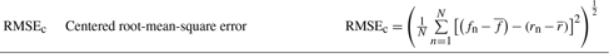
